In [8]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers datasets accelerate
!pip install pandas numpy matplotlib scikit-learn tqdm

Looking in indexes: https://download.pytorch.org/whl/cpu


Starting GPT-2 Fine-tuning Example...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Starting manual training...


Epoch 2/2: 100%|██████████| 90/90 [00:12<00:00,  7.00it/s, loss=0.00343]


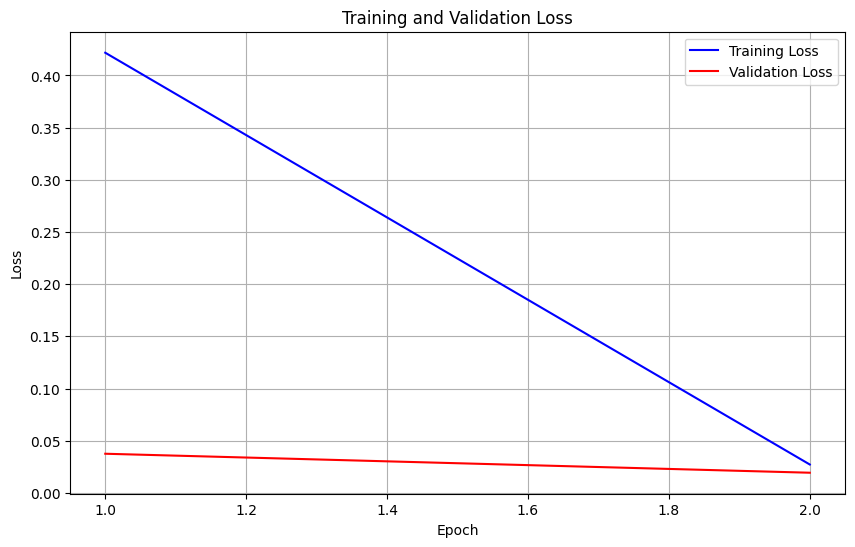

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



SAMPLE GENERATED TEXT

Prompt: 'Machine learning is'
Generated 1: Machine learning is a powerful tool for data analysis and pattern recognition.
Generated 2: Machine learning is a powerful tool for data analysis and pattern recognition.
----------------------------------------

Prompt: 'Neural networks are'
Generated 1: Neural networks are interconnected systems that process information.
Generated 2: Neural networks are interconnected systems that process information.
----------------------------------------

Prompt: 'The key advantage of deep learning'
Generated 1: The key advantage of deep learning is the flexibility of its methods.
Generated 2: The key advantage of deep learning is that it is a powerful tool for data analysis and pattern recognition.
----------------------------------------

EVALUATION


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


Final perplexity: 1.02

Model saved to: ./gpt2-simple-finetuned


In [9]:
# GPT-2 Fine-tuning on Domain-Specific Text
# Updated for compatibility with current transformers library versions

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # Import AdamW from torch.optim
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    GPT2Config,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer
)
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import json
import logging
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class TextDataset(Dataset):
    """Custom dataset for text data"""
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # For language modeling, input_ids and labels are the same
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': encoding['input_ids'].flatten()
        }

class GPT2Trainer:
    """GPT-2 Fine-tuning trainer"""

    def __init__(self, model_name='gpt2', max_length=512):
        self.model_name = model_name
        self.max_length = max_length
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize tokenizer and model
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.to(self.device)

        logger.info(f"Model loaded on {self.device}")
        logger.info(f"Model has {sum(p.numel() for p in self.model.parameters())} parameters")

    def prepare_data(self, texts, test_size=0.1, random_state=42):
        """Prepare training and validation datasets"""

        # Split data
        train_texts, val_texts = train_test_split(
            texts, test_size=test_size, random_state=random_state
        )

        # Create datasets
        train_dataset = TextDataset(train_texts, self.tokenizer, self.max_length)
        val_dataset = TextDataset(val_texts, self.tokenizer, self.max_length)

        logger.info(f"Training samples: {len(train_dataset)}")
        logger.info(f"Validation samples: {len(val_dataset)}")

        return train_dataset, val_dataset

    def train(self, train_dataset, val_dataset, output_dir='./gpt2-finetuned',
              num_epochs=3, batch_size=4, learning_rate=5e-5, warmup_steps=500,
              save_steps=1000, eval_steps=500, logging_steps=100):
        """Fine-tune the model"""

        # Training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            overwrite_output_dir=True,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            eval_strategy="steps",
            eval_steps=eval_steps,
            logging_steps=logging_steps,
            save_steps=save_steps,
            warmup_steps=warmup_steps,
            learning_rate=learning_rate,
            weight_decay=0.01,
            logging_dir='./logs',
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=2,
            prediction_loss_only=True,
            dataloader_pin_memory=False,
            remove_unused_columns=False,
            report_to=None  # Disable wandb/tensorboard logging
        )

        # Initialize trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
        )

        # Train the model
        logger.info("Starting training...")
        train_result = trainer.train()

        # Save the model
        trainer.save_model()

        # Save training metrics
        with open(os.path.join(output_dir, 'training_results.json'), 'w') as f:
            json.dump(train_result.metrics, f, indent=2)

        logger.info("Training completed!")
        return trainer, train_result

    def train_manual(self, train_dataset, val_dataset, output_dir='./gpt2-finetuned',
                    num_epochs=3, batch_size=4, learning_rate=5e-5):
        """Alternative manual training loop without HF Trainer"""

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Set up optimizer
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)

        # Training loop
        self.model.train()
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            epoch_train_loss = 0

            # Training phase
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for batch in progress_bar:
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()
                progress_bar.set_postfix({'loss': loss.item()})

            # Validation phase
            self.model.eval()
            epoch_val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    epoch_val_loss += outputs.loss.item()

            avg_train_loss = epoch_train_loss / len(train_loader)
            avg_val_loss = epoch_val_loss / len(val_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            logger.info(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            self.model.train()

        # Save model
        os.makedirs(output_dir, exist_ok=True)
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        return train_losses, val_losses

    def generate_text(self, prompt, max_length=100, num_return_sequences=1,
                     temperature=1.0, do_sample=True, top_k=50, top_p=0.95):
        """Generate text using the fine-tuned model"""

        self.model.eval()

        # Encode the prompt
        input_ids = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)

        # Generate text
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids,
                max_length=max_length,
                num_return_sequences=num_return_sequences,
                temperature=temperature,
                do_sample=do_sample,
                top_k=top_k,
                top_p=top_p,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Decode the generated text
        generated_texts = []
        for output in outputs:
            text = self.tokenizer.decode(output, skip_special_tokens=True)
            generated_texts.append(text)

        return generated_texts

    def evaluate_perplexity(self, test_dataset, batch_size=8):
        """Calculate perplexity on test dataset"""

        dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.model.eval()

        total_loss = 0
        total_samples = 0

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_loss += loss.item() * input_ids.size(0)
                total_samples += input_ids.size(0)

        avg_loss = total_loss / total_samples
        perplexity = torch.exp(torch.tensor(avg_loss))

        logger.info(f"Average loss: {avg_loss:.4f}")
        logger.info(f"Perplexity: {perplexity:.4f}")

        return perplexity.item()

def load_domain_specific_data(file_path, text_column='text'):
    """Load domain-specific text data"""

    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        texts = df[text_column].dropna().tolist()
    elif file_path.endswith('.txt'):
        with open(file_path, 'r', encoding='utf-8') as f:
            texts = [line.strip() for line in f if line.strip()]
    elif file_path.endswith('.json'):
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            texts = [item[text_column] for item in data if text_column in item]
    else:
        raise ValueError("Unsupported file format. Use CSV, TXT, or JSON.")

    logger.info(f"Loaded {len(texts)} text samples")
    return texts

def plot_training_losses(train_losses, val_losses):
    """Plot training and validation losses"""

    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simple example without dependencies on external files
def simple_example():
    """Simple example that works immediately"""

    print("Starting GPT-2 Fine-tuning Example...")

    # Create sample domain-specific data
    sample_texts = [
        "Machine learning is a powerful tool for data analysis and pattern recognition.",
        "Neural networks consist of interconnected nodes that process information.",
        "Deep learning models have revolutionized natural language processing tasks.",
        "Training data quality significantly impacts the performance of AI models.",
        "Transformer architectures have become the standard for language modeling.",
        "Artificial intelligence systems can learn from large datasets.",
        "The attention mechanism allows models to focus on relevant information.",
        "Fine-tuning pre-trained models is an effective transfer learning approach.",
        "Natural language understanding requires sophisticated computational methods.",
        "Computer vision tasks benefit from convolutional neural network architectures."
    ] * 20  # Repeat to create more training data

    # Initialize trainer
    trainer = GPT2Trainer(model_name='gpt2', max_length=128)

    # Prepare data
    train_dataset, val_dataset = trainer.prepare_data(sample_texts)

    # Use manual training (more reliable than HF Trainer)
    print("Starting manual training...")
    train_losses, val_losses = trainer.train_manual(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        output_dir='./gpt2-simple-finetuned',
        num_epochs=2,
        batch_size=2,  # Small batch size for demo
        learning_rate=5e-5
    )

    # Plot training history
    plot_training_losses(train_losses, val_losses)

    # Generate sample text
    print("\n" + "="*50)
    print("SAMPLE GENERATED TEXT")
    print("="*50)

    prompts = [
        "Machine learning is",
        "Neural networks are",
        "The key advantage of deep learning"
    ]

    for prompt in prompts:
        print(f"\nPrompt: '{prompt}'")
        generated_texts = trainer.generate_text(
            prompt=prompt,
            max_length=50,
            num_return_sequences=2,
            temperature=0.8
        )

        for i, text in enumerate(generated_texts):
            print(f"Generated {i+1}: {text}")
        print("-" * 40)

    # Evaluate perplexity
    print("\n" + "="*50)
    print("EVALUATION")
    print("="*50)

    perplexity = trainer.evaluate_perplexity(val_dataset)
    print(f"Final perplexity: {perplexity:.2f}")

    print(f"\nModel saved to: ./gpt2-simple-finetuned")

# Main execution
def main():
    """Main execution function with more configuration options"""

    # For a quick test, run the simple example
    simple_example()

if __name__ == "__main__":
    # Install required packages first:
    # !pip install torch transformers pandas numpy matplotlib scikit-learn tqdm

    main()

# Additional utility functions

def create_sample_dataset(output_file='sample_domain_data.csv', num_samples=1000):
    """Create a sample dataset for testing"""

    sample_texts = [
        "In the field of artificial intelligence, machine learning algorithms analyze patterns in data.",
        "Deep learning models utilize neural networks with multiple layers for complex tasks.",
        "Natural language processing enables computers to understand and generate human language.",
        "Computer vision systems can identify and classify objects in images and videos.",
        "Reinforcement learning agents learn through interaction with their environment.",
        "Data preprocessing is crucial for training effective machine learning models.",
        "Feature engineering involves selecting and transforming input variables.",
        "Model evaluation requires careful consideration of metrics and validation strategies.",
        "Hyperparameter tuning optimizes model performance through systematic search.",
        "Transfer learning leverages pre-trained models for new tasks and domains.",
    ]

    # Generate more samples with variations
    extended_texts = []
    for i in range(num_samples):
        base_text = sample_texts[i % len(sample_texts)]
        extended_texts.append(f"{base_text} This represents sample {i+1} in our dataset.")

    # Save to CSV
    df = pd.DataFrame({'text': extended_texts})
    df.to_csv(output_file, index=False)
    print(f"Sample dataset created: {output_file}")

def load_and_train_from_file(data_file, text_column='text', output_dir='./gpt2-custom'):
    """Load data from file and train model"""

    # Load data
    texts = load_domain_specific_data(data_file, text_column)

    # Initialize trainer
    trainer = GPT2Trainer(model_name='gpt2', max_length=512)

    # Prepare data
    train_dataset, val_dataset = trainer.prepare_data(texts)

    # Train model
    train_losses, val_losses = trainer.train_manual(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        output_dir=output_dir,
        num_epochs=3,
        batch_size=4,
        learning_rate=5e-5
    )

    return trainer, train_losses, val_losses